# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu

In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/FZ4025.10 Fintech/Tareas/S3/Project 2/df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

In [5]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + " " + df_news['SUMMARY']
display(df_news.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,2 Dow Jones Stocks with Promising Prospects an...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,3 S&P 500 Stocks Skating on Thin Ice The S&P 5...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,3M Rises 15.8% YTD: Should You Buy the Stock N...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...,3 Cash-Producing Stocks with Questionable Fund...


In [6]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        if len(documents) != len(metadata):
            raise ValueError("Number of documents and metadata entries must match.")

        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.embedding_model.encode(documents)
        print(f"Initialized CustomVectorStore with {len(documents)} documents.")

    def search(self, query, k=5, metadata_filter=None):
        # Determine candidate indices
        indices = list(range(len(self.documents)))
        if metadata_filter is not None:
            indices = [i for i in indices if metadata_filter(self.metadata[i])]
            if not indices:
                return []

        query_embedding = self.embedding_model.encode([query])

         # Compute similarities on filtered subset
        subset_embeddings = self.embeddings[indices]
        similarities = cosine_similarity(query_embedding, subset_embeddings)[0]

        # Get indices of top k results
        top_k_indices = np.argsort(similarities)[::-1]

        results = []
        for index in top_k_indices:
            original_index = indices[index] # Get original index from filtered_indices
            document = self.documents[original_index]
            metadata = self.metadata[original_index]
            score = similarities[index]
            results.append((document, metadata, score)) # Add this line to append results
            if len(results) == k:
                break
        return results


## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


In [8]:
documents = df_news['EMBEDDED_TEXT'].tolist()
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict('records')

store = CustomVectorStore(embedding_model, documents, metadata)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Initialized CustomVectorStore with 4871 documents.


In [9]:
# Testing the search with a query
store.search("Apple earnings", k=3)

[('Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain. Thursday morning, Aptiv reported first-quarter earnings per share of $1.69 from sales of $4.8 billion in sales. Wall Street was looking for EPS of $1.53 from sales of $4.8 billion.',
  {'PUBLICATION_DATE': datetime.date(2025, 5, 1),
   'TICKER': 'APTV',
   'PROVIDER': 'Barrons.com'},
  np.float32(0.5717155)),
 ('ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, but a minor dip in net income and earnings per share. Alongside this, the company reaffirmed its quarterly dividend of $1.03 per share. These updates coincide with a 4.5% price increase over the week, which aligns with broader market gains of 5.2%. Despite fluctuations in major indices due to economic data and earnings reports from numerous companies,...',
  {'PUBLICATION_DATE': datetime.date(2025, 4, 

In [10]:
# Testing the search using the metadata_filter
store.search("Apple earnings", k=3, metadata_filter=lambda m: m["TICKER"] == "AAPL" )

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[("47% of Berkshire Hathaway's $276 Billion Warren Buffett-Led Portfolio Is Invested in 3 Dividend Stocks Apple has developed an ecosystem of tech devices that its customers love and are willing to trade up to have.  American Express has numerous earnings streams, and a younger cohort of cardholders is driving growth.  Coca-Cola's business has proven resilient under pressure, and it reliably boosts its dividends.",
  {'PUBLICATION_DATE': datetime.date(2025, 5, 31),
   'TICKER': 'AAPL',
   'PROVIDER': 'Motley Fool'},
  np.float32(0.48964393)),
 ("Warren Buffett Holds Apple Stock Despite Tariffs and Buys a Restaurant Stock Up 4,500% in 15 Years Warren Buffett's Berkshire Hathaway continued to hold Apple and added to its stake in Domino’s Pizza in the first quarter.  Apple stock looks expensive with earnings increasing just 8% in the second quarter, and tariffs could slow profit growth even further.  Warren Buffett manages the vast majority of Berkshire Hathaway's stock portfolio, and the

In [11]:
# Testing the search using another metadata_filter
store.search("Apple earnings", k=5, metadata_filter=lambda m: m["PROVIDER"] == "Motley Fool" )

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[("47% of Berkshire Hathaway's $276 Billion Warren Buffett-Led Portfolio Is Invested in 3 Dividend Stocks Apple has developed an ecosystem of tech devices that its customers love and are willing to trade up to have.  American Express has numerous earnings streams, and a younger cohort of cardholders is driving growth.  Coca-Cola's business has proven resilient under pressure, and it reliably boosts its dividends.",
  {'PUBLICATION_DATE': datetime.date(2025, 5, 31),
   'TICKER': 'AXP',
   'PROVIDER': 'Motley Fool'},
  np.float32(0.48964393)),
 ("47% of Berkshire Hathaway's $276 Billion Warren Buffett-Led Portfolio Is Invested in 3 Dividend Stocks Apple has developed an ecosystem of tech devices that its customers love and are willing to trade up to have.  American Express has numerous earnings streams, and a younger cohort of cardholders is driving growth.  Coca-Cola's business has proven resilient under pressure, and it reliably boosts its dividends.",
  {'PUBLICATION_DATE': datetime.d

## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


In [12]:
ai_announcement_results = store.search("AI announcement", k=50)

for document, metadata, score in ai_announcement_results:
    print(f"TICKER: {metadata['TICKER']}")
    print(f"PUBLICATION_DATE: {metadata['PUBLICATION_DATE']}")
    print(f"PROVIDER: {metadata['PROVIDER']}")
    print(f"Similarity Score: {score:.4f}")
    print(f"Document Text: {document}")
    print("-" * 50)

TICKER: ADBE
PUBLICATION_DATE: 2025-05-27
PROVIDER: Investor's Business Daily
Similarity Score: 0.5567
Document Text: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
--------------------------------------------------
TICKER: JKHY
PUBLICATION_DATE: 2025-03-17
PROVIDER: Insider Monkey
Similarity Score: 0.5467
Document Text: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
--------------------------------------------------
TICKER: PLTR
PUBLICATION_DATE: 2025-05-31
PROVIDER: Motley Fool


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [13]:
# CODE HERE
# Use as many coding cells as you need
ticker_counts = Counter(metadata['TICKER'] for document, metadata, score in ai_announcement_results)

print("Top companies (by TICKER) in the top 50 AI announcement search results:")
for ticker, count in ticker_counts.most_common(10):
    print(f"{ticker}: {count}")

Top companies (by TICKER) in the top 50 AI announcement search results:
PLTR: 5
BKR: 3
AMD: 3
CTSH: 3
QCOM: 2
META: 2
AMZN: 2
MSFT: 2
EXPE: 2
INTC: 2


The top 3 companies are:

*   Palantir (software). This company has been expanding through AI-powered
partnerships and platforms.

*   Baker Hughes (Oil and gas). This company is investing in AI infrastructure and data centers.

*   Advanced Micro Technologies (Semi-conductor). This company is a core supplier of AI chips.

In [14]:
print("Top 5 results from ai_announcement_results:")
for i in range(min(5, len(ai_announcement_results))):
    document, metadata, score = ai_announcement_results[i]
    print(f"  Score: {score:.4f}, Ticker: {metadata['TICKER']}, Date: {metadata['PUBLICATION_DATE']}, Provider: {metadata['PROVIDER']}")
    print(f"  Document: {document[:200]}...") # Print first 200 characters

Top 5 results from ai_announcement_results:
  Score: 0.5567, Ticker: ADBE, Date: 2025-05-27, Provider: Investor's Business Daily
  Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving tec...
  Score: 0.5467, Ticker: JKHY, Date: 2025-03-17, Provider: Insider Monkey
  Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where ...
  Score: 0.5353, Ticker: PLTR, Date: 2025-05-31, Provider: Motley Fool
  Document: Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake Shares of both Palantir and Snowflake have delivered healthy gains in 2025 despite the broader stock market weakness.  Palantir stock ...
  Score: 0.5179, Ticker: QCOM, Date: 2025-05-28, Provider: Simply Wall St.
  D

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

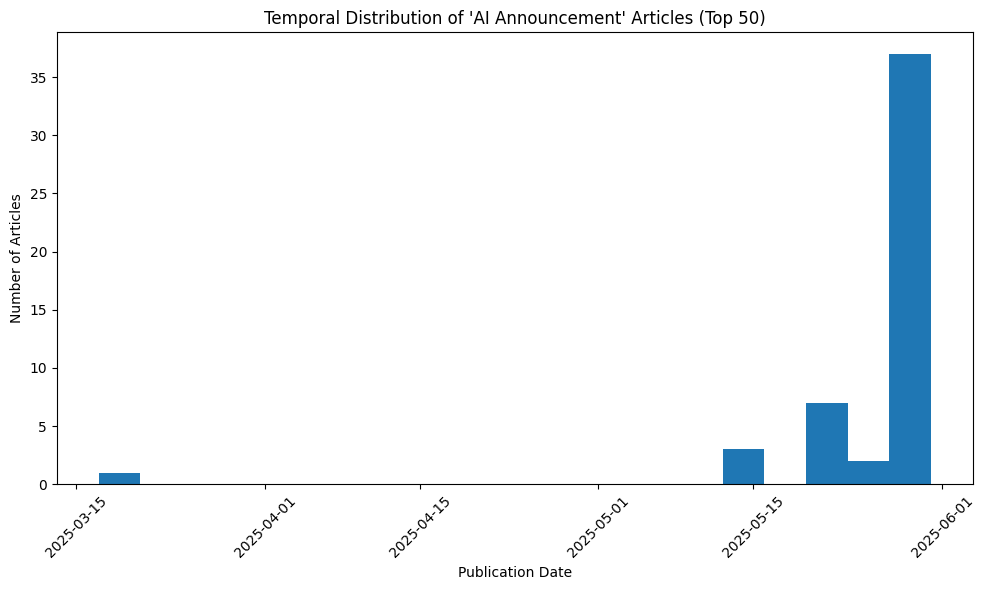

In [15]:
publication_dates = [metadata['PUBLICATION_DATE'] for document, metadata, score in ai_announcement_results]

# Convert date objects to pandas datetime for plotting
date_times = pd.to_datetime(publication_dates)

plt.figure(figsize=(10, 6))
plt.hist(date_times, bins=20) # Adjust bins as needed
plt.xlabel("Publication Date")
plt.ylabel("Number of Articles")
plt.title("Temporal Distribution of 'AI Announcement' Articles (Top 50)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It looks like the AI announcements increased drastically at the end of May. This could have been driven by the earning reports.

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embeddings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [16]:
# Encode the text into embeddings
faiss_embeddings = embedding_model.encode(documents)

# Normalize the embeddings to unit length for cosine similarity with IndexFlatIP
faiss_embeddings = faiss_embeddings.astype('float32')
faiss.normalize_L2(faiss_embeddings)

print("Embeddings generated and normalized for FAISS.")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Embeddings generated and normalized for FAISS.


In [17]:
faiss_embeddings.shape[1]

384

In [18]:
# Initialize the FAISS index
# The dimension of the embeddings is 384 for 'all-MiniLM-L6-v2'
embedding_dimension = faiss_embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dimension)

# Add the document embeddings to the index
index.add(faiss_embeddings)

print(f"FAISS index created with {index.ntotal} vectors.")

FAISS index created with 4871 vectors.


### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [19]:
class FaissVectorStore:
    def __init__(self, index, metadata, embedding_model, documents):
        self.index = index
        self.metadata = metadata
        self.embedding_model = embedding_model
        self.documents = documents

        if len(documents) != len(metadata):
            raise ValueError("documents and metadata must have the same length.")

        emb = embedding_model.encode(documents, convert_to_numpy=True, normalize_embeddings=True)
        self.embeddings = emb.astype("float32")
        self.embedding_dim = self.embeddings.shape[1]

         # Build FAISS index for inner product (since the embeddings were normalized, inner product == cosine similarity)
        self.index = faiss.IndexFlatIP(self.embedding_dim)
        self.index.add(self.embeddings)  # add all vectors

    def search(self, query, k=5, metadata_filter=None):

      # Prepare candidate indices if metadata_filter is provided
        candidate_indices = np.arange(len(self.documents))
        if metadata_filter is not None:
            candidate_indices = np.array(
                [i for i, m in enumerate(self.metadata) if metadata_filter(m)], dtype=np.int64
            )
            if candidate_indices.size == 0:
                return []

        # Encode and normalize query
        q_emb = self.embedding_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
        q_emb = q_emb.astype("float32").reshape(1, -1)  # shape (1, dim)

        # If no metadata filter, we can query the full index directly
        if metadata_filter is None:
            # inner product on normalized vectors gives cosine similarity
            D, I = self.index.search(q_emb, k)  # D: similarities, I: indices
            results = []
            for score, idx in zip(D[0], I[0]):
                if idx == -1:
                    continue
                results.append((self.documents[idx], self.metadata[idx], float(score)))
            return results

        # If metadata filtered, we need to compute similarities only over the subset
        # Extract subset embeddings and do manual inner products
        subset_embeddings = self.embeddings[candidate_indices]  # already normalized
        # Cosine similarity = inner product
        sims = np.dot(q_emb, subset_embeddings.T).flatten()  # shape (len(candidate_indices),)
        if sims.size == 0:
            return []
        # Get k among filtered
        k = min(k, sims.size)
        sorted_idx = np.argsort(-sims)[:k]
        results = []
        for rank in sorted_idx:
            orig_idx = int(candidate_indices[rank])
            results.append((self.documents[orig_idx], self.metadata[orig_idx], float(sims[rank])))
        return results

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [20]:
faiss_documents = df_news['EMBEDDED_TEXT'].tolist()
faiss_metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict('records')

faiss_store = FaissVectorStore(index, faiss_metadata, embedding_model, faiss_documents)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [21]:
faiss_ai_announcement_results = faiss_store.search("AI announcement", k=50)

print("Top 50 results from FAISS Vector Store for 'AI announcement':")
for document, metadata, score in faiss_ai_announcement_results:
    print(f"TICKER: {metadata['TICKER']}")
    print(f"PUBLICATION_DATE: {metadata['PUBLICATION_DATE']}")
    print(f"PROVIDER: {metadata['PROVIDER']}")
    print(f"Similarity Score: {score:.4f}")
    print(f"Document Text: {document}")
    print("-" * 50)

Top 50 results from FAISS Vector Store for 'AI announcement':
TICKER: ADBE
PUBLICATION_DATE: 2025-05-27
PROVIDER: Investor's Business Daily
Similarity Score: 0.5567
Document Text: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
--------------------------------------------------
TICKER: JKHY
PUBLICATION_DATE: 2025-03-17
PROVIDER: Insider Monkey
Similarity Score: 0.5467
Document Text: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
--------------------------------------------------
TI

In [22]:
# Test the store with metadata filter for Ticker
faiss_store.search("Apple earnings", k=3, metadata_filter=lambda m: m["TICKER"] == "AAPL" )

[("47% of Berkshire Hathaway's $276 Billion Warren Buffett-Led Portfolio Is Invested in 3 Dividend Stocks Apple has developed an ecosystem of tech devices that its customers love and are willing to trade up to have.  American Express has numerous earnings streams, and a younger cohort of cardholders is driving growth.  Coca-Cola's business has proven resilient under pressure, and it reliably boosts its dividends.",
  {'PUBLICATION_DATE': datetime.date(2025, 5, 31),
   'TICKER': 'AAPL',
   'PROVIDER': 'Motley Fool'},
  0.489643931388855),
 ("Warren Buffett Holds Apple Stock Despite Tariffs and Buys a Restaurant Stock Up 4,500% in 15 Years Warren Buffett's Berkshire Hathaway continued to hold Apple and added to its stake in Domino’s Pizza in the first quarter.  Apple stock looks expensive with earnings increasing just 8% in the second quarter, and tariffs could slow profit growth even further.  Warren Buffett manages the vast majority of Berkshire Hathaway's stock portfolio, and the comp

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [23]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'

]

In [29]:
for query in test_queries:
    print(f"--- Comparison DataFrames for query: '{query}' ---")

    # Get results from Custom Vector Store
    custom_results = store.search(query, k=5)
    custom_df_data = []
    if custom_results:
        for doc, meta, score in custom_results:
            custom_df_data.append({
                'Score': score,
                'Ticker': meta['TICKER'],
                'Date': meta['PUBLICATION_DATE'],
                'Provider': meta['PROVIDER'],
                'Document (Snippet)': doc[:150] + '...' # Snippet for readability
            })
    custom_df = pd.DataFrame(custom_df_data)
    print("\nCustom Vector Store Results (DataFrame):")
    display(custom_df)

    # Get results from FAISS Vector Store
    faiss_results = faiss_store.search(query, k=5)
    faiss_df_data = []
    if faiss_results:
        for doc, meta, score in faiss_results:
            faiss_df_data.append({
                'Score': score,
                'Ticker': meta['TICKER'],
                'Date': meta['PUBLICATION_DATE'],
                'Provider': meta['PROVIDER'],
                'Document (Snippet)': doc[:150] + '...' # Snippet for readability
            })
    faiss_df = pd.DataFrame(faiss_df_data)
    print("\nFAISS Vector Store Results (DataFrame):")
    display(faiss_df)

    print("-" * 70)

--- Comparison DataFrames for query: 'Stock price drop' ---

Custom Vector Store Results (DataFrame):


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.570609,PKG,2025-05-29,StockStory,3 Reasons to Avoid PKG and 1 Stock to Buy Inst...
1,0.570009,HUM,2025-05-27,StockStory,2 Reasons to Like HUM and 1 to Stay Skeptical ...
2,0.553263,CRL,2025-05-21,StockStory,"Guardant Health, Evolent Health, Charles River..."
3,0.548273,GNRC,2025-05-28,StockStory,3 Industrials Stocks Walking a Fine Line Even ...
4,0.544070,KR,2025-05-27,Zacks,Kroger (KR) Stock Drops Despite Market Gains: ...



FAISS Vector Store Results (DataFrame):


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.570609,PKG,2025-05-29,StockStory,3 Reasons to Avoid PKG and 1 Stock to Buy Inst...
1,0.570009,HUM,2025-05-27,StockStory,2 Reasons to Like HUM and 1 to Stay Skeptical ...
2,0.553263,CRL,2025-05-21,StockStory,"Guardant Health, Evolent Health, Charles River..."
3,0.548273,GNRC,2025-05-28,StockStory,3 Industrials Stocks Walking a Fine Line Even ...
4,0.544070,KR,2025-05-27,Zacks,Kroger (KR) Stock Drops Despite Market Gains: ...


----------------------------------------------------------------------
--- Comparison DataFrames for query: 'Layoffs' ---

Custom Vector Store Results (DataFrame):


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.559312,CVX,2025-05-30,Fox Business,Chevron to layoff approximately 200 employees ...
1,0.536945,FDX,2025-05-29,Sourcing Journal,FedEx Plans More Than 300 Layoffs At Texas Fac...
2,0.473717,CVX,2025-05-29,Offshore Technology,Chevron to implement around 800 job cuts in Te...
3,0.440082,CVX,2025-05-30,Hart Energy,Chevron Confirms 200 Permian Layoffs—Not 800 C...
4,0.432764,IP,2025-05-30,Packaging Dive,"Georgia-Pacific, Greif, Silgan detailed layoff..."



FAISS Vector Store Results (DataFrame):


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.559312,CVX,2025-05-30,Fox Business,Chevron to layoff approximately 200 employees ...
1,0.536945,FDX,2025-05-29,Sourcing Journal,FedEx Plans More Than 300 Layoffs At Texas Fac...
2,0.473717,CVX,2025-05-29,Offshore Technology,Chevron to implement around 800 job cuts in Te...
3,0.440082,CVX,2025-05-30,Hart Energy,Chevron Confirms 200 Permian Layoffs—Not 800 C...
4,0.432764,IP,2025-05-30,Packaging Dive,"Georgia-Pacific, Greif, Silgan detailed layoff..."


----------------------------------------------------------------------
--- Comparison DataFrames for query: 'Mergers and acquisitions' ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Custom Vector Store Results (DataFrame):


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.567179,KEY,2025-05-31,Motley Fool,2 Large Regional Bank Stocks That Could Get Ac...
1,0.499904,STE,2025-05-21,Zacks,AST Business Growth & Strategic Acquisitions S...
2,0.492716,COF,2025-05-27,Zacks,COF Stock Tanks 5.9% Post Discover Merger: A G...
3,0.482873,TTWO,2025-05-21,Simply Wall St.,Take-Two Interactive Software (NasdaqGS:TTWO) ...
4,0.456271,ANSS,2025-05-29,GuruFocus.com,Synopsys (SNPS) and Ansys (ANSS) Told to Trim ...



FAISS Vector Store Results (DataFrame):


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.567179,KEY,2025-05-31,Motley Fool,2 Large Regional Bank Stocks That Could Get Ac...
1,0.499904,STE,2025-05-21,Zacks,AST Business Growth & Strategic Acquisitions S...
2,0.492716,COF,2025-05-27,Zacks,COF Stock Tanks 5.9% Post Discover Merger: A G...
3,0.482872,TTWO,2025-05-21,Simply Wall St.,Take-Two Interactive Software (NasdaqGS:TTWO) ...
4,0.456271,SNPS,2025-05-29,GuruFocus.com,Synopsys (SNPS) and Ansys (ANSS) Told to Trim ...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


----------------------------------------------------------------------
--- Comparison DataFrames for query: 'Fed interest rate' ---

Custom Vector Store Results (DataFrame):


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.422370,DOC,2024-09-13,Yahoo Finance Video,How the 10-year yield affects REITs Interest r...
1,0.417553,NEM,2025-05-28,TipRanks,"NEM, FNV, and WPM Primed for Gold Rush 2.0 as ..."
2,0.415996,BLK,2025-05-29,Yahoo Finance UK,Bitcoin price slips as Fed minutes flag US inf...
3,0.411951,AWK,2025-05-08,Zacks,Fed Leaves Interest Rates Unchanged: 4 Low-Bet...
4,0.411951,AES,2025-05-08,Zacks,Fed Leaves Interest Rates Unchanged: 4 Low-Bet...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



FAISS Vector Store Results (DataFrame):


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.422370,DOC,2024-09-13,Yahoo Finance Video,How the 10-year yield affects REITs Interest r...
1,0.417553,NEM,2025-05-28,TipRanks,"NEM, FNV, and WPM Primed for Gold Rush 2.0 as ..."
2,0.415996,BLK,2025-05-29,Yahoo Finance UK,Bitcoin price slips as Fed minutes flag US inf...
3,0.411951,AWK,2025-05-08,Zacks,Fed Leaves Interest Rates Unchanged: 4 Low-Bet...
4,0.411951,AES,2025-05-08,Zacks,Fed Leaves Interest Rates Unchanged: 4 Low-Bet...


----------------------------------------------------------------------
--- Comparison DataFrames for query: 'Regulation' ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Custom Vector Store Results (DataFrame):


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.394460,BK,2025-05-15,Financial Times,US poised to dial back bank rules imposed in w...
1,0.335781,NSC,2025-05-21,FreightWaves,"Regulatory risk a red signal to rail mergers, ..."
2,0.330037,IT,2025-05-27,CFO.com,Gartner’s Alex Bant breaks down the new realit...
3,0.312426,SO,2025-05-20,Zacks,SO Reaches a Settlement for Extension of Rate ...
4,0.305027,SNPS,2025-05-29,Insider Monkey,Synopsys (SNPS) Halts Guidance After BIS China...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



FAISS Vector Store Results (DataFrame):


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.394460,BK,2025-05-15,Financial Times,US poised to dial back bank rules imposed in w...
1,0.335781,NSC,2025-05-21,FreightWaves,"Regulatory risk a red signal to rail mergers, ..."
2,0.330037,IT,2025-05-27,CFO.com,Gartner’s Alex Bant breaks down the new realit...
3,0.312426,SO,2025-05-20,Zacks,SO Reaches a Settlement for Extension of Rate ...
4,0.305027,SNPS,2025-05-29,Insider Monkey,Synopsys (SNPS) Halts Guidance After BIS China...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


----------------------------------------------------------------------
--- Comparison DataFrames for query: 'Cryptocurrency' ---

Custom Vector Store Results (DataFrame):


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.557132,PYPL,2025-05-27,Zacks,3 Crypto-Centric Stocks in Focus as Bitcoin Re...
1,0.503619,COIN,2025-05-28,Investor's Business Daily,Cryptocurrency Prices And News: Bitcoin Hovers...
2,0.428726,COIN,2025-05-28,Barrons.com,Bitcoin Price Falls. Key Crypto Conference Fai...
3,0.409191,COIN,2025-05-27,Barrons.com,Robinhood vs. Coinbase: Why One Stock Is a Muc...
4,0.371243,PYPL,2025-05-28,Motley Fool,2 Stocks Down 30% and 18% to Buy Hand Over Fis...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



FAISS Vector Store Results (DataFrame):


,Score,Ticker,Date,Provider,Document (Snippet)
0,0.557132,PYPL,2025-05-27,Zacks,3 Crypto-Centric Stocks in Focus as Bitcoin Re...
1,0.503619,COIN,2025-05-28,Investor's Business Daily,Cryptocurrency Prices And News: Bitcoin Hovers...
2,0.428726,COIN,2025-05-28,Barrons.com,Bitcoin Price Falls. Key Crypto Conference Fai...
3,0.409191,COIN,2025-05-27,Barrons.com,Robinhood vs. Coinbase: Why One Stock Is a Muc...
4,0.371243,PYPL,2025-05-28,Motley Fool,2 Stocks Down 30% and 18% to Buy Hand Over Fis...


----------------------------------------------------------------------


### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

I don't see any differences. This could be because we're using the same embedding model in both. ('all-MiniLM-L6-v2')
The cosine similarity used for the vector custom store is mathematically equivalent to the IndexFlatIP on L2-normalized vectors (inner product).


## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [25]:
# Load the second embedding model
embedding_model_mpnet = SentenceTransformer('all-mpnet-base-v2')

# Re-create documents and metadata lists to ensure consistency
documents = df_news['EMBEDDED_TEXT'].tolist()
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict('records')

# Instantiate a CustomVectorStore with the second model
store_mpnet = CustomVectorStore(embedding_model_mpnet, documents, metadata)

Initialized CustomVectorStore with 4871 documents.


In [26]:
# Compare results for the test queries
for query in test_queries:
    print(f"--- Comparison for query: '{query}' ---")

    print("\nCustom Vector Store Results (all-MiniLM-L6-v2):")
    custom_results_mini = store.search(query, k=5)
    if custom_results_mini:
        for doc, meta, score in custom_results_mini:
            print(f"  Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
            print(f"  Document: {doc[:200]}...") # Print first 200 characters
    else:
        print("  No results found.")


    print("\nCustom Vector Store Results (all-mpnet-base-v2):")
    custom_results_mpnet = store_mpnet.search(query, k=5)
    if custom_results_mpnet:
         for doc, meta, score in custom_results_mpnet:
             print(f"  Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
             print(f"  Document: {doc[:200]}...") # Print first 200 characters
    else:
        print("  No results found.")

    print("-" * 70)

--- Comparison for query: 'Stock price drop' ---

Custom Vector Store Results (all-MiniLM-L6-v2):
  Score: 0.5706, Ticker: PKG, Date: 2025-05-29, Provider: StockStory
  Document: 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, its stock price has dropped 21.6% to $195 per shar...
  Score: 0.5700, Ticker: HUM, Date: 2025-05-27, Provider: StockStory
  Document: 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24.3% to a new 52-week low of $224.50 per share. Thi...
  Score: 0.5533, Ticker: CRL, Date: 2025-05-21, Provider: StockStory
  Document: Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in the afternoon session after the major indices pulled...
  Score: 0.5483, Ticker: GNRC, Date: 2025-05-28

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  Score: 0.4913, Ticker: UPS, Date: 2025-05-23, Provider: FreightWaves
  Document: Freight industry layoffs surge across California, Texas Freight-related layoffs hit Amazon, FedEx, UPS and F&S Produce West over the past week. The post Freight industry layoffs surge across Californi...
  Score: 0.4913, Ticker: FDX, Date: 2025-05-23, Provider: FreightWaves
  Document: Freight industry layoffs surge across California, Texas Freight-related layoffs hit Amazon, FedEx, UPS and F&S Produce West over the past week. The post Freight industry layoffs surge across Californi...
  Score: 0.4467, Ticker: IP, Date: 2025-05-30, Provider: Packaging Dive
  Document: Georgia-Pacific, Greif, Silgan detailed layoff plans in May Amcor and International Paper also disclosed forthcoming changes as they integrate recent acquisitions. LanzaTech, which has worked to creat...
  Score: 0.4269, Ticker: CPRT, Date: 2025-05-23, Provider: Yahoo Finance Video
  Document: Apple tariff threats, Copart Q3 earnings, Booz 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  Score: 0.5062, Ticker: JPM, Date: 2025-05-30, Provider: Reuters
  Document: JPMorgan CEO Dimon backs US taxing carried interest, warns of bond market trouble (Reuters) -JPMorgan Chase CEO Jamie Dimon said on Friday that the U.S. should be taxing carried interest, joining the ...
  Score: 0.4547, Ticker: KKR, Date: 2025-05-21, Provider: Bloomberg
  Document: Traders Brace for Treasury 10-Year Yield at 5% as Mood Sours (Bloomberg) -- Traders are piling into bets that long-term Treasury yields will surge on concerns over the US government’s swelling debt an...
  Score: 0.4527, Ticker: ADM, Date: 2025-05-09, Provider: TipRanks
  Document: Trump announces trade deal, BoE lowers Bank Rate: Morning Buzz The major averages were sharply higher near noon amid increased optimism around trade, as well as a decrease in U.S. initial jobless clai...
  Score: 0.4527, Ticker: WBD, Date: 2025-05-09, Provider: TipRanks
  Document: Trump announces trade deal, BoE lowers Bank Rate: Morning Buzz The major

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  Score: 0.4939, Ticker: COIN, Date: 2025-05-28, Provider: Barrons.com
  Document: Bitcoin Price Falls. Key Crypto Conference Fails to Lift Digital Coins. Bitcoin’s  price edged down despite a flurry of crypto news, including an endorsement by Vice President JD Vance in a speech at ...
  Score: 0.4784, Ticker: FITB, Date: 2025-05-16, Provider: Bloomberg
  Document: Fifth Third Plans More Crypto After Five Years Studying Assets (Bloomberg) -- Fifth Third Bancorp. began forging relationships with crypto companies about five years ago, but held off on major investm...
  Score: 0.4775, Ticker: CME, Date: 2025-05-29, Provider: Simply Wall St.
  Document: CME Group (NasdaqGS:CME) Expands Crypto Offerings With New Reference Rates And Indices CME Group (NasdaqGS:CME) recently announced its collaboration with CF Benchmarks on launching new cryptocurrency ...
  Score: 0.4726, Ticker: PYPL, Date: 2025-05-27, Provider: Zacks
  Document: 3 Crypto-Centric Stocks in Focus as Bitcoin Resumes Its Rally

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

Both models seem to retrieve the news correctly based on the querys. There are some differences in the specific news but all of them are related to the query provided. The mpnet model got higher similarity scores. More detailed comparison is shown below:


 **Stock price drop**

mini 0.54 to 0.57

All news mention "Stock drops"

mpnet 0.56 to 0.59

Uses "stock tumbles", "stock fall",
Both models look like they retrieved the correct news about the query provided.

**Layoffs**

mini 0.43 to 0.55

All news mention "layoffs", ticker CVX was shown 3 times from 3 different providers.

mpnet 0.42 to 0.49

The 2 bottom news don't necessarily talk about layoffs. Top 1 and 2 shows the same article but assigned to different tickers (UPS and FDX), because of them being on the same industry,

In this case the mini model seems to be performing better.

**Mergers and acquisitions**

mini 0.45 to 0.56

All news mention Merges and/or acquisitions.

mpnet 0.54 to 0.66

The last ticker news don't mention any merging or acquisition yet it shows a good similarity value (0.54)

AST and KEY tickers news are shown in both models

**Fed interest rate**

mini 0.41 to 0.42

mpnet 0.44 to 0.50

Both models showed similar news related to the Fed interest rate, although this term is not explicitly mentioned in the summaries.

**Regulation**

mini 0.30 to 0.39

mpnet 0.33 to 0.39

The scores were low but the news show good relation to the query provided.


**Cryptocurrency**

mini 0.37 to 0.55

mpnet 0.39 to 0.49

Both models look like they retrieved the correct news about crypto.



## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

In the Custom vector store, the cosine similarity already handles the normalization of the vectors.
In the FAISS IP (inner product) store, the normalization has to be applied in order to get the same metric (cosine similarity) and ensure fairness across documents.


### **Q6.**  What would happen if vectors were not normalized before indexing?

Some documents with "longer" embeddings can be wrongly ranked above more semantically relevant vectors.
The model can give more importance to vectors pointing in different directions that may not be as relevant as others.




## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


FAISS vector store, because it supports ANN indexes that can handle a higher quantity of vectors than the cosine_similarity. It also has GPU support for more acceleration.


### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

The FAISS vector store will scale better.

The Custom vector store does a brute-force comparison, creating a matrix that compares similarity with all the vectors, so at 5 million articles the model will be doing 5 million dot products with every query, representing a lot of computing cost and slower performance.

FAISS can be configured to do Approximate Nearest Neighbor search, inspecting only a small fraction of the documents, while still maintaining high recall. This model also supports compressed representations than can reduce storage, enabling more vectors to live in RAM.